In [1]:
import gzip
import psutil
from itertools import islice
import sys
from math import sqrt, log
from time import time
import seaborn as sns
import pandas as pd

# HyperLogLog implementations

## hyperloglog: 

In [1]:
!pip install hyperloglog

  Using cached hyperloglog-0.0.14.tar.gz (36 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for hyperloglog: filename=hyperloglog-0.0.14-py3-none-any.whl size=37927 sha256=93cd212bb5b897c0f1829b5f9e02a125c0c6ca16cb74ffa2512b1d8d5edf4bdd
  Stored in directory: /home/nikolare/.cache/pip/wheels/76/d9/23/3d8ebf80b75462b1c231ced0ae5834eb144e777a79db528289
Successfully built hyperloglog


In [8]:
%%timeit -n 1 -r 1
import hyperloglog
card = 10**7
hll = hyperloglog.HyperLogLog(0.005)  # error rate 0.5%
for i in range(card):
    hll.add(str(i))
estimate = hll.card()
nreg = hll.m
print('number of registers: ', nreg) 
print('theoretical relative standard error: ', 1.04 / sqrt(nreg))
print('empirical relative error: ', (estimate - card) / card)

number of registers:  65536
theoretical relative standard error:  0.0040625
empirical relative error:  -0.001088252159224078
14.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### 14.6s for adding 10M items => 4h for 10B

## HLL:

In [12]:
!pip install HLL

In [22]:
# %%timeit -n 1 -r 1
from HLL import HyperLogLog
card = 10**7
hll = HyperLogLog(16, sparse=False) # use 2^16 registers for error rate 0.5%
for i in range(10**7):
    hll.add(str(i))

estimate = hll.cardinality()
nreg = hll.size()
print('number of registers: ', nreg) 
print('theoretical relative standard error: ', 1.04 / sqrt(nreg))
print('empirical relative error: ', (estimate - card) / card)

number of registers:  65536
theoretical relative standard error:  0.0040625
empirical relative error:  -0.0058843


### 1.85s for adding 10M items = > 0.5h for 10B

In [10]:
from math import sqrt
from HLL import HyperLogLog
card = 10**8
for p in range(10,40, 10):
    hll = HyperLogLog(p=p, sparse=False)
    st = time()
    for i in range(card):
        hll.add(str(i))

    print(time()-st,  (hll.cardinality()-card)/card, 1.04 / sqrt(2**p))

22.136672735214233 -0.02985981 0.0325
22.2760169506073 -0.00121852 0.001015625
37.752153158187866 -2.125e-05 3.173828125e-05


### 20 / 40 s for adding 100M items => 0.8/1.6 h for 10B items with relative stderr of 0.1% / 0.003%

## datasketch:

In [11]:
!pip install datasketch

  Using cached datasketch-1.5.9-py3-none-any.whl (76 kB)
  Obtaining dependency information for scipy>=1.0.0 from https://files.pythonhosted.org/packages/a8/cc/c36f3439f5d47c3b13833ce6687b43a040cc7638c502ac46b41e2d4f3d6f/scipy-1.11.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 11.2 MB/s eta 0:00:00m eta 0:00:010:01:01


In [3]:
%%timeit -n 1 -r 1
from datasketch import HyperLogLogPlusPlus
hll = HyperLogLogPlusPlus(16)  # 2**16 registers give 0.5% relative stderr
card = 10**7
for i in range(card):
    hll.update(str(i).encode('utf-8'))

estimate = hll.count()
nreg = hll.m
print('number of registers: ', nreg) 
print('theoretical relative standard error: ', 1.04 / sqrt(nreg))
print('empirical relative error: ', (estimate - card) / card)

number of registers:  65536
theoretical relative standard error:  0.0040625
empirical relative error:  -0.0034109912245158104
34.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [4]:
%%timeit -n 1 -r 1
from datasketch import HyperLogLog
hll = HyperLogLog(16)  # 2**16 registers give 0.5% relative stderr
card = 10**7
for i in range(card):
    hll.update(str(i).encode('utf-8'))

estimate = hll.count()
nreg = hll.m
print('number of registers: ', nreg) 
print('theoretical relative standard error: ', 1.04 / sqrt(nreg))
print('empirical relative error: ', (estimate - card) / card)

number of registers:  65536
theoretical relative standard error:  0.0040625
empirical relative error:  -0.001774693542262353
34.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Slower than previous ones!

## dnbaker/sketch:

In [5]:
!rm -rf sketch && git clone --recursive https://github.com/dnbaker/sketch

Cloning into 'sketch'...
remote: Enumerating objects: 8263, done.
remote: Counting objects: 100% (630/630), done.
remote: Compressing objects: 100% (189/189), done.
remote: Total 8263 (delta 483), reused 537 (delta 440), pack-reused 7633
Receiving objects: 100% (8263/8263), 4.57 MiB | 10.05 MiB/s, done.
Resolving deltas: 100% (6022/6022), done.
Submodule 'include/vec/sleef' (https://github.com/shibatch/sleef/) registered for path 'include/vec/sleef'
Submodule 'pybind11' (https://github.com/pybind/pybind11) registered for path 'pybind11'
Cloning into '/home/nikolare/_projects/hplt/warc2text-runner/overlap/sketch/include/vec/sleef'...
remote: Enumerating objects: 4865, done.        
remote: Counting objects: 100% (170/170), done.        
remote: Compressing objects: 100% (98/98), done.        
remote: Total 4865 (delta 97), reused 125 (delta 72), pack-reused 4695        
Receiving objects: 100% (4865/4865), 4.68 MiB | 7.62 MiB/s, done.
Resolving deltas: 100% (3820/3820), done.
Cloning in

In [7]:
!cd sketch; git checkout cddae5fb5293b5024cd9fd2662d423214461c77b  # python bindings don't work in the last commit 

Note: switching to 'cddae5fb5293b5024cd9fd2662d423214461c77b'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at cddae5f Update compact_vector to eliminate warnings.


In [8]:
!cd sketch/python && python3 setup.py build_ext -j4 && python3 setup.py install

/home/nikolare/anaconda3/envs/jupyterai/lib/python3.10/site-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
/home/nikolare/anaconda3/envs/jupyterai/lib/python3.10/site-packages/setuptools/dist.py:509: InformationOnly: Normalizing 'v0.18' to '0.18'
  self.metadata.version = self._normalize_version(
running build_ext
creating tmp
gcc -pthread -B /home/nikolare/anaconda3/envs/jupyterai/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/nikolare/anaconda3/envs/jupyterai/include -fPIC -O2 -isystem /home/nikolare/an

creating build/lib.linux-x86_64-cpython-310
g++ -pthread -B /home/nikolare/anaconda3/envs/jupyterai/compiler_compat -shared -Wl,-rpath,/home/nikolare/anaconda3/envs/jupyterai/lib -Wl,-rpath-link,/home/nikolare/anaconda3/envs/jupyterai/lib -L/home/nikolare/anaconda3/envs/jupyterai/lib -Wl,-rpath,/home/nikolare/anaconda3/envs/jupyterai/lib -Wl,-rpath-link,/home/nikolare/anaconda3/envs/jupyterai/lib -L/home/nikolare/anaconda3/envs/jupyterai/lib build/temp.linux-x86_64-cpython-310/bf.o -o build/lib.linux-x86_64-cpython-310/sketch_bf.cpython-310-x86_64-linux-gnu.so -lgomp -lz
building 'sketch_hmh' extension
gcc -pthread -B /home/nikolare/anaconda3/envs/jupyterai/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/nikolare/anaconda3/envs/jupyterai/include -fPIC -O2 -isystem /home/nikolare/anaconda3/envs/jupyterai/include -fPIC -I/home/nikolare/_projects/hplt/warc2text-runner/overlap/sketch/python/.eggs/pybind11-2.11.1-py3.10.egg/pybind11/incl

g++ -pthread -B /home/nikolare/anaconda3/envs/jupyterai/compiler_compat -shared -Wl,-rpath,/home/nikolare/anaconda3/envs/jupyterai/lib -Wl,-rpath-link,/home/nikolare/anaconda3/envs/jupyterai/lib -L/home/nikolare/anaconda3/envs/jupyterai/lib -Wl,-rpath,/home/nikolare/anaconda3/envs/jupyterai/lib -Wl,-rpath-link,/home/nikolare/anaconda3/envs/jupyterai/lib -L/home/nikolare/anaconda3/envs/jupyterai/lib build/temp.linux-x86_64-cpython-310/util.o -o build/lib.linux-x86_64-cpython-310/sketch_util.cpython-310-x86_64-linux-gnu.so -lgomp -lz
In file included from ../python/pysketch.h:15,
                 from hmh.cpp:1:
../include/sketch/hmh.h: In member function ‘double sketch::hmh::hmh_t::union_size(const sketch::hmh::hmh_t&) const’:
../include/sketch/hmh.h:424:65: warning: ‘rems’ may be used uninitialized []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wmaybe-uninitialized-Wmaybe-uninitialized]8;;]
  424 |                 ret += mrx2 - double(((const type *)&rems)[j]) *

removing 'build/bdist.linux-x86_64/egg' (and everything under it)
Processing sketch-0.18-py3.10-linux-x86_64.egg
creating /home/nikolare/anaconda3/envs/jupyterai/lib/python3.10/site-packages/sketch-0.18-py3.10-linux-x86_64.egg
Extracting sketch-0.18-py3.10-linux-x86_64.egg to /home/nikolare/anaconda3/envs/jupyterai/lib/python3.10/site-packages
Adding sketch 0.18 to easy-install.pth file

Installed /home/nikolare/anaconda3/envs/jupyterai/lib/python3.10/site-packages/sketch-0.18-py3.10-linux-x86_64.egg
Processing dependencies for sketch==0.18
Searching for pybind11==2.11.1
Best match: pybind11 2.11.1
Processing pybind11-2.11.1-py3.10.egg
pybind11 2.11.1 is already the active version in easy-install.pth
detected new path './sketch-0.18-py3.10-linux-x86_64.egg'
Installing pybind11-config script to /home/nikolare/anaconda3/envs/jupyterai/bin

Using /home/nikolare/_projects/hplt/warc2text-runner/overlap/sketch/python/.eggs/pybind11-2.11.1-py3.10.egg
Finished processing dependencies for sketc

In [14]:
%%timeit -n 1 -r 1
import sketch
hll = sketch.hll.hll(16)  # 2**16 registers give 0.5% relative stderr
card = 10**7
for i in range(card):
    hll.addh(str(i))
estimate = hll.report()
# nreg = hll.m
# print('number of registers: ', nreg) 
print('theoretical relative standard error: ', hll.relative_error())
print('empirical relative error: ', (estimate - card) / card)

theoretical relative standard error:  0.0040584375
empirical relative error:  0.0024197322313331067
3.67 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [17]:
from math import sqrt
import sketch
card = 10**8
for p in range(10,40, 10):
    hll = sketch.hll.hll(p)  # 2**16 registers give 0.5% relative stderr
    st = time()
    for i in range(card):
        hll.addh(str(i))

    print(time()-st,  (hll.report()-card)/card, 1.04 / sqrt(2**p))

42.4220130443573 0.025248016839572937 0.0325
43.646475315093994 -0.00039723790660098194 0.001015625
62.721622705459595 -5.439140012308955e-05 3.173828125e-05


### 2x slower compared to HLL

# SetSketch implementations

## dnbaker:

In [53]:
%%timeit 
import sketch
ss = sketch.setsketch.CSetSketch(2**16)  # 2**16 registers give 0.5% relative stderr
card = 10**7
for i in range(card):
    ss.addh(str(i))
estimate = ss.report()
# nreg = hll.m
# print('number of registers: ', nreg) 
# print('theoretical relative standard error: ', ss.relative_error())
print('empirical relative error: ', (estimate - card) / card)

empirical relative error:  0.012423492214080319
empirical relative error:  0.012423492214080319
empirical relative error:  0.012423492214080319
empirical relative error:  0.012423492214080319
empirical relative error:  0.012423492214080319
empirical relative error:  0.012423492214080319
empirical relative error:  0.012423492214080319
empirical relative error:  0.012423492214080319
4 s ± 38.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 4s for 10M items => 1.1h for 10B items

In [125]:
from math import sqrt
import sketch

card = 10**7
for p in range(12, 22, 2):
    m = 2**p
    ss = sketch.setsketch.CSetSketch(m)  # 2**16 registers give 0.5% relative stderr
    st = time()
    for i in range(card):
        ss.addh(str(i))

    rel_realerr = (ss.report() - card) / card
    rel_stderr = 1.0 / sqrt(m)
    print(f'{p}: {rel_realerr/rel_stderr:.3f}, {time()-st:.2f}s,  {rel_realerr}, {rel_stderr}')

12: -0.573, 4.15s,  -0.008957229244843126, 0.015625
14: 0.450, 4.22s,  0.003515398152990453, 0.0078125
16: 3.180, 4.45s,  0.012423492214080319, 0.00390625
18: 0.951, 5.83s,  0.0018566568084277212, 0.001953125
20: -0.014, 21.26s,  -1.3449034900031984e-05, 0.0009765625


In [105]:
from math import sqrt
import sketch

l = []
for p in range(16, 20, 2):
    m = 2**p
    ss = sketch.setsketch.CSetSketch(m)  # 2**16 registers give 0.5% relative stderr

    for k in range(27):
        for i in range(2**k, 2**(k+1)):
            ss.addh(str(i))

        card = 2**(k+1)-1
        rel_realerr = (ss.report() - card) / card
        rel_stderr = 1.0 / sqrt(m)
        l.append({'card':card, 'm':m, 'err_ratio': rel_realerr/rel_stderr})


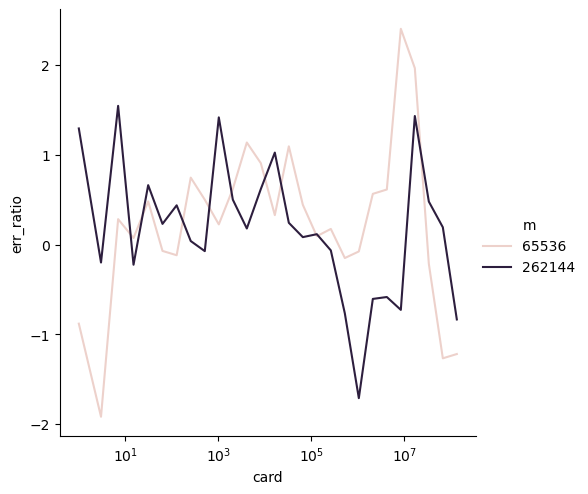

In [106]:
g = sns.relplot(data=pd.DataFrame(l), x='card', y='err_ratio', hue='m', kind='line')
g.set(xscale="log")

In [19]:
def print_err(var, relative_stderr, est, real):
    relative_realerr = (est-real)*1.0 / real
    errerr = relative_realerr / relative_stderr
#     CI95 = (est*(1-2*relative_stderr), est*(1+2*relative_stderr))
    print('*' if abs(errerr)>2.0 else '', errerr, f'{var} est: {est}*(1+-{relative_stderr}) real: {real}')
    

In [21]:
# %%timeit -n 1 -r 1
import sketch
import sympy
debug = False

m = 2**18
hll, hll2 = sketch.setsketch.CSetSketch(m), sketch.setsketch.CSetSketch(m)

if debug: ss1, ss2 = set(), set()
# step1, step2, maxval = 1, 5, 2*10**6
# step1, step2, maxval = sympy.nextprime(125), sympy.nextprime(208), 10**9
step1, step2, maxval = 2087, 1249, 3*10**8
# step1, step2, maxval = 31, 17, 10**7
assert sympy.isprime(step1) and sympy.isprime(step2)
for i in range(step1, maxval+1, step1):
    hll.addh(str(i))
    if debug: ss1.add(str(i))

for i in range(step2, maxval+1, step2):
    hll2.addh(str(i))
    if debug: ss2.add(str(i))
    
hll.write('tmp1')
hll2.write('tmp2')

hll, hll2 = sketch.setsketch.CSetSketch('tmp1'), sketch.setsketch.CSetSketch('tmp2')

jaccard_est = sketch.setsketch.jaccard_index(hll, hll2)

card1, card2 = maxval // step1, maxval // step2
intersection = maxval // (step1*step2)
union = card1 + card2 - intersection
jaccard = intersection / union

if debug: 
    assert len(ss1)==card1 and len(ss2)==card2
    assert len(ss1.union(ss2))==union
    assert len(ss1.intersection(ss2))==intersection
    assert len(ss1.intersection(ss2)) / len(ss1.union(ss2))==jaccard
    
print_err('card1', 1/sqrt(m), hll.report(), card1)    
print_err('card2', 1/sqrt(m), hll2.report(), card2)    
print_err('Union', 1/sqrt(m), hll2.union(hll).report(), union)    
print_err('Jaccard', sqrt((1./jaccard_est-1)/m), jaccard_est, jaccard)    

m = hll.to_numpy().shape[0]
print(m)

 1.3096168156052996 card1 est: 144114.68259451722*(1+-0.001953125) real: 143747
 -0.3696143198702529 card2 est: 240018.60468219087*(1+-0.001953125) real: 240192
 0.5257121193817818 Union est: 384218.1033759953*(1+-0.001953125) real: 383824
 0.05176156881187808 Jaccard est: 0.000301361083984375*(1+-0.11249183592970488) real: 0.0002996164908916587
262144


J = 1 / (step1 + step2 - 1) => step1 + step2 = 1/J + 1

card1 / card2 = step2 / step1

In [3]:
import sympy
J=0.0003
card1 = 3*10**6
card2 = 5*10**6
step1 = sympy.nextprime((1 + 1./J) / (1. + 1.0*card1/card2))
step2 = sympy.nextprime((1 + 1./J) - step1)
print(step1, step2)

2087 1249


In [5]:
dir(sketch.setsketch)

['ByteSetSketch',
 'CSetSketch',
 'FSetSketch',
 'ShortSetSketch',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'csf_from_np',
 'css_from_np',
 'ebs_from_np',
 'ess_from_np',
 'jaccard_index']